<a href="https://colab.research.google.com/github/jamesnatoli/ABCD_Exercise_HTT/blob/main/HTT_ABCD_2012OpenData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABCD Exercise: Higgs to TauTau QCD estimation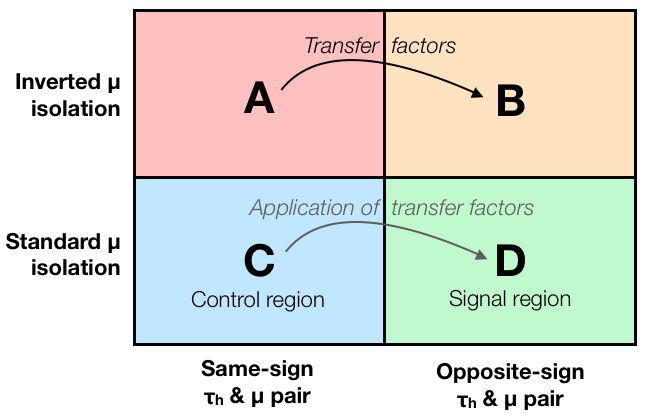

A critical part of high energy physics analyses is predicting known sources of backgrounds as a function of different variables. We then can compare these predictions with observed data to draw conclusions or make measurements

Many background processes can be estimated from simulation. That is, using event generators like MadGraph or Pythia (or both), we can produce events for specific processes **almost** as if they had been observed in the detector. Events produced with this method are called **Monte Carlo Simulations**

These simulations are never perfect, so observed data is used to validate them. Also, some background processes simply can't be simulated with a high enough accuracy.

This exercise focuses on estimated QCD Multijet background from data, as this is a common example of a process which can't be estimated from simulation

In [22]:
#@title Graphic Example
!wget 'https://github.com/jamesnatoli/ABCD_Exercise_HTT/blob/main/abcd_diagram.png' &> /dev/null
from PIL import Image
image = Image.open('abcd_diagram.png')
width, height = image.size
mode = image.mode
#print(f"Image loaded successfully. Dimensions: {width}x{height}, Mode: {mode}")

import matplotlib
#matplotlib.pyplot.imshow(image)
#matplotlib.pyplot.axis('off')  # Hide axes for a cleaner look
#matplotlib.pyplot.show()

This method uses 2 unique variables to divide the data in to 4 different phase spaces. One of these phase spaces, here denoted **Region D**, is our signal region.

The assumption is that the ratio of events in **D to C** is the same as the ratio of events in **B to A**.
$$\frac{D}{C} = \frac{B}{A}$$
$$D = C \times \frac{B}{A}$$

This method boils down to counting the number of events in a control region, and then scaling (normalizing) those events by the ratio of events in a separate region.

Our practical task is then to get the appropriate number of events in each region and apply the normalization factors such that we can estimate the QCD Multijet background process accurately

Before we begin, we need to import some python modules, which allow us to store and manipulate the data

In [23]:
import pandas as pd
import numpy as np

Now we can load the events, which is stored in csv (comma separated values) format. This storage method is very low-level, but allows values to be read by many different applications

In [24]:
#@title Loading Events

inputs = {'DYJetsToLL_ZLL':    'ZLL', # Drell-Yan --> 2 Leptons
          'DYJetsToLL_ZTT':    'ZTT', # Drell-Yan --> 2 Taus
          'W1JetsToLNu':       'W1J', # W Boson + 1 Jet --> Lepton + Neutrino
          'W2JetsToLNu':       'W2J', # W Boson + 2 Jets --> Lepton + Neutrino
          'W3JetsToLNu':       'W3J', # W Boson + 3 Jets --> Lepton + Neutrino
          'TTbar':             'TT',  # Top + AntiTop
          'VBF_HToTauTau':     'qqH', # Vector Boson Fusion
          'GluGluToHToTauTau': 'ggH', # Gluon Gluon Fusion
          'Run2012B_TauPlusX': 'dataRunB', # Data, Era B (4.485 /fb)
          'Run2012C_TauPlusX': 'dataRunC', # Data, Era C (6.614 /fb)
          }

events = pd.DataFrame()
to_concat = []
labels = []
for ifile, label in inputs.items():
  # we use read_csv function from pandas to read the events into a "data frame"
  print(f'Loading {ifile}...')
  if 'DYJetsToLL' in ifile: ifile = 'DYJetsToLL'
  prefix = 'https://raw.githubusercontent.com/jamesnatoli/ABCD_Exercise_HTT/main/'
  input_df = pd.read_csv(prefix + ifile + 'Skim_store.csv')
  input_df['label'] = np.full(len(input_df), label) # add column with the labels
  to_concat.append(input_df)
  labels.append(label)

# now we put them all in the same object
events = pd.concat(to_concat)

# lets take a peak inside...
events.head()

Loading DYJetsToLL_ZLL...
Loading DYJetsToLL_ZTT...
Loading W1JetsToLNu...
Loading W2JetsToLNu...
Loading W3JetsToLNu...
Loading TTbar...
Loading VBF_HToTauTau...
Loading GluGluToHToTauTau...
Loading Run2012B_TauPlusX...
Loading Run2012C_TauPlusX...


,Unnamed: 0,njets,npv,pt_1,eta_1,phi_1,m_1,iso_1,q_1,mt_1,...,m_vis,pt_vis,mjj,ptjj,jdeta,gen_match,run,weight,sample_name,label
0,0,0,17,17.545351,-0.787461,1.523578,0.105658,0.127352,1,19.278289,...,62.613564,12.580107,-999.0,-999.0,-999.0,True,194533,1.319055,DYJetsToLLSkim,ZLL
1,1,0,19,21.322285,0.734122,2.959332,0.105658,0.069089,-1,8.830149,...,49.865227,6.382893,-999.0,-999.0,-999.0,True,194533,1.319055,DYJetsToLLSkim,ZLL
2,2,0,11,21.152906,-0.417071,-1.380073,0.105658,0.159884,1,0.875113,...,68.722560,23.421194,-999.0,-999.0,-999.0,True,194533,1.319055,DYJetsToLLSkim,ZLL
3,3,0,13,26.634708,1.823677,1.022758,0.105658,0.000000,-1,34.184495,...,64.033040,8.310519,-999.0,-999.0,-999.0,True,200519,1.319055,DYJetsToLLSkim,ZLL
4,4,1,15,19.996640,-0.504789,2.123815,0.105658,0.042825,1,0.869223,...,21.241768,40.054832,-999.0,-999.0,-999.0,True,200519,1.319055,DYJetsToLLSkim,ZLL


These events have been made publicly available by the CMS Collaboration and contains a mix of simulated events and data that was observed in 2012 using proton-proton collisions at a center of mass energy of 8 TeV

We apply "cuts" to the events, selecting only those which meet specific requirements.

First, lets select only events with an isolated muon
Then, we'll require the transverse mass of the muon to be less than a threshold, which will reduce the background from the W+Jets process

In [25]:
events = events[ # Split up the Drell-Yan sample in to ZLL and ZTT
    ((events['label'] != 'ZTT') | ((events['label'] == 'ZTT') & events['gen_match'])) &
    ((events['label'] != 'ZLL') | ((events['label'] == 'ZLL') & ~events['gen_match']))
    ]

# Now select isolated events
iso_events = events[
    (events['iso_1'] < 0.1) & # Require isolated muon for signal region
    (events['mt_1'] < 30) # Muon transverse mass cut for W+jets suppression
    ]

# let's take another peak now...
iso_events.head()

,Unnamed: 0,njets,npv,pt_1,eta_1,phi_1,m_1,iso_1,q_1,mt_1,...,m_vis,pt_vis,mjj,ptjj,jdeta,gen_match,run,weight,sample_name,label
13,13,0,21,59.290077,-0.185510,-2.429436,0.105658,0.094182,-1,9.183883,...,122.37241,32.600033,-999.0,-999.0,-999.0,False,200519,1.319055,DYJetsToLLSkim,ZLL
18,18,1,11,29.510347,1.302142,0.888718,0.105658,0.040348,1,17.233894,...,102.09473,18.583984,-999.0,-999.0,-999.0,False,206859,1.319055,DYJetsToLLSkim,ZLL
42,42,0,12,53.665688,-1.072835,-1.091055,0.105658,0.000000,-1,8.437947,...,76.50453,32.321810,-999.0,-999.0,-999.0,False,200519,1.319055,DYJetsToLLSkim,ZLL
47,47,1,25,28.043259,1.359530,3.002496,0.105658,0.028013,1,2.420709,...,82.98091,14.395263,-999.0,-999.0,-999.0,False,200519,1.319055,DYJetsToLLSkim,ZLL
62,62,0,5,51.222710,-0.221325,-2.377358,0.105658,0.000000,-1,15.276152,...,98.21988,41.185360,-999.0,-999.0,-999.0,False,200519,1.319055,DYJetsToLLSkim,ZLL


#Selecting Phase Spaces: Signal Region
As seen in the peek, this is now a subset of the original events. Let's narrow the phase space further, by selecting events with that have lepton pairs of an opposite sign. This is our signal region and corresponds to **Region D**

Why do we expect lepton pairs with opposite sign?

In [27]:
OS_events = iso_events[
    iso_events['q_1']*iso_events['q_2'] < 0
]

Now, let's plot a specific variable for these events. We'll choose the `visible mass`, which represents the mass of particles that aren't neutrinos.

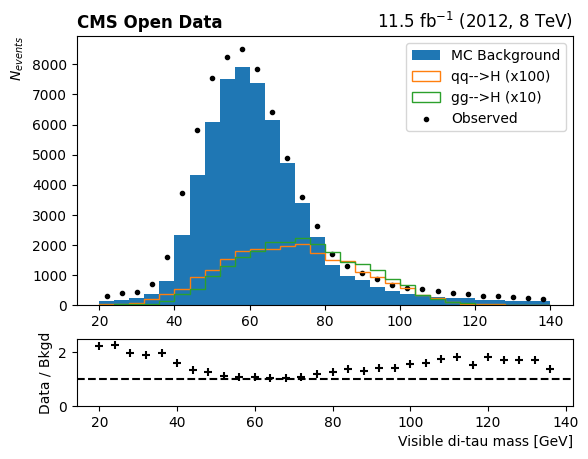

In [49]:
# Import the necessary modules
import matplotlib.pyplot as plt

# Group these names for convenience
signals     = ['qqH', 'ggH']
backgrounds = ['ZLL', 'ZTT', 'W1J', 'W2J', 'W3J', 'TT']
data        = ['dataRunB', 'dataRunC']

# Create 2 plots
fig, (ax1, ax2) = plt.subplots( nrows=2, height_ratios=[4,1])

# Plot Monte Carlo (MC) Backgrounds
bkgdcounts, bins, patches = ax1.hist( OS_events[OS_events['label'].isin(backgrounds)]['m_vis'],
                                     bins=30, range=[20, 140], weights=OS_events[OS_events['label'].isin(backgrounds)]['weight'], label='MC Background')

# Plot Signals, mostly for fun
qqHcounts, bins, patches = ax1.hist( OS_events[OS_events['label']=='qqH']['m_vis'],
                                    bins=30, range=[20, 140], weights=OS_events[OS_events['label']=='qqH']['weight']*100, histtype='step', label='qq-->H (x100)')
ggHcounts, bins, patches = ax1.hist( OS_events[OS_events['label']=='ggH']['m_vis'],
                                    bins=30, range=[20, 140], weights=OS_events[OS_events['label']=='ggH']['weight']*10, histtype='step', label='gg-->H (x10)')

# Plot Data
datacounts, bins = np.histogram( OS_events[OS_events['label'].isin(data)]['m_vis'], bins=30, range=[20, 140])
ax1.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), datacounts, marker='.', color='black', label='Observed')

# Name the axis and give the title
# ax1.set_xlabel('Visible di-tau mass [GeV]', loc='right')
ax1.set_ylabel(r'$N_{events}$', loc='top')
ax1.set_title('CMS Open Data', fontweight='bold', loc='left')
ax1.set_title(r'11.5 fb$^{-1}$ (2012, 8 TeV)', loc='right')

# Now add a legend
ax1.legend()

# Add a Ratio Plot
ax2.scatter(bins[:-1], datacounts / bkgdcounts, marker='+', color='black')
ax2.axhline(1.0, linestyle='--', color='black')

ax2.set_xlabel('Visible di-tau mass [GeV]', loc='right')
ax2.set_ylabel('Data / Bkgd')
ax2.set_ylim( [0, 2.5])

# Show the plots now...
plt.show()

What do we notice about this plot? How well does the background simulation agree with the observed data points? What could be the reason for this?

Take a look at the ratio plot to visualize the comparison better...

#Selecting Phase Spaces: Control Region C

Let's take our first step in estimating the QCD Multijet background by creating a new phase space. This will consist of events with same-signed leptons and corresonds to **Region C**

This shase space is not exclusive to QCD events, but we can estimate the contributions from other backgrounds in this region from the simulations.

How will we isolate the QCD contribution?

In [34]:
SS_events = iso_events[
    iso_events['q_1']*iso_events['q_2'] > 0
]

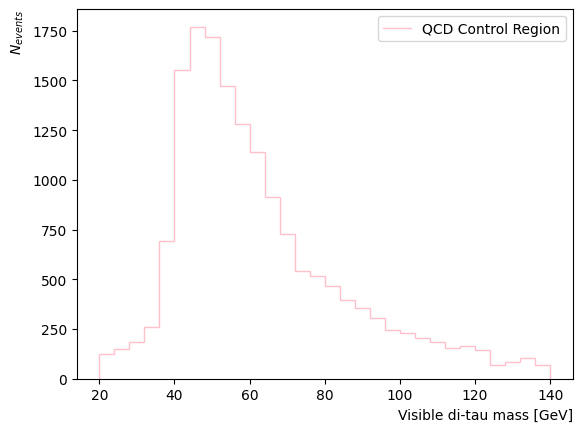

In [36]:
# Count Data in Opposite Sign (OS) Control Region (CR)
datacounts_CR, bins = np.histogram( SS_events[SS_events['label'].isin(data)]['m_vis'], bins=30, range=[20, 140])

# Count MC Backgrounds in the CR
bkgdcounts_CR, bins = np.histogram( SS_events[SS_events['label'].isin(backgrounds)]['m_vis'], bins=30, range=[20, 140])

# Subtract the MC Backgrounds from the Data
QCDcounts_CR = datacounts_CR - bkgdcounts_CR

# Safety check to remove negative bins
QCDcounts_CR = [0 if i < 0.0 else i for i in QCDcounts_CR]

# Draw the QCD in this control region
plt.stairs( QCDcounts_CR, bins, color='pink', label='QCD Control Region')

# Beautify
plt.ylabel(r'$N_{events}$', loc='top')
plt.xlabel('Visible di-tau mass [GeV]', loc='right')
plt.legend()

# Show the plots now...
plt.show()

#Selecting Phase Spaces: Regions A and B
This is the QCD in our control region (C), so we need to derive the "transfer factor" to extrapolate the contribution to the signal region.

Where could this transfer factor come from?

In [37]:
# Now select isolated events
antiiso_events = events[
    (events['mt_1'] < 30) & # Muon transverse mass cut for W+jets suppression
    (events['iso_1'] > 0.1) # INVERT the muon isolation requirement
    ]

# Select SS events from the anti-isolated region (A)
SS_antiiso_events = antiiso_events [
    antiiso_events['q_1']*antiiso_events['q_2'] < 0
    ]

# Select OS events from the anti-isolated region (B)
OS_antiiso_events = antiiso_events [
    antiiso_events['q_1']*antiiso_events['q_2'] > 0
    ]

We now have the 2 other phase spaces defined: Same-Sign and Opposite-Sign in anti-isolated events

To get the ratio of events, we'll plot the data and subtract the MC backgrounds in each phase space

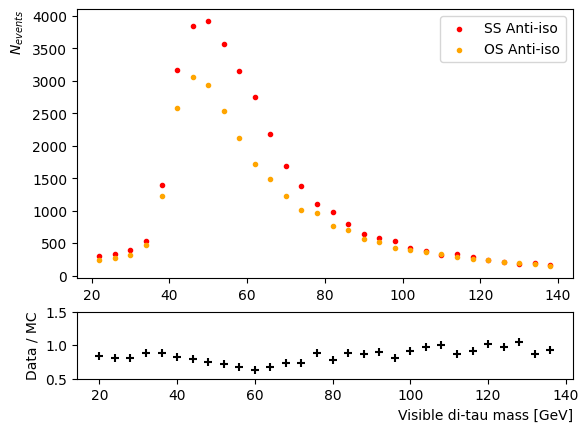

In [41]:
fig, (ax1, ax2) = plt.subplots( nrows=2, height_ratios=[4,1])

datacounts_SS_antiiso, bins = np.histogram( SS_antiiso_events[SS_antiiso_events['label'].isin(data)]['m_vis'], bins=30, range=[20, 140])
datacounts_OS_antiiso, bins = np.histogram( OS_antiiso_events[OS_antiiso_events['label'].isin(data)]['m_vis'], bins=30, range=[20, 140])

ax1.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), datacounts_SS_antiiso, marker='.', color='red', label='SS Anti-iso')
ax1.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), datacounts_OS_antiiso, marker='.', color='orange', label='OS Anti-iso')

# Beautify
# ax1.set_xlabel('Visible di-tau mass [GeV]', loc='right')
ax1.set_ylabel(r'$N_{events}$', loc='top')
ax1.legend()

# Add a Ratio Plot
ax2.scatter(bins[:-1], datacounts_OS_antiiso / datacounts_SS_antiiso, marker='+', color='black')
# ax2.axhline(1.0, linestyle='--', color='black')

ax2.set_xlabel('Visible di-tau mass [GeV]', loc='right')
ax2.set_ylabel('Data / MC')
ax2.set_ylim( [0.5, 1.5])

# Show the plots now...
plt.show()

In [40]:
ratio = datacounts_OS_antiiso / datacounts_SS_antiiso
print(ratio)

[0.83673469 0.80674847 0.805      0.87735849 0.87714286 0.81591411
 0.79330044 0.74923391 0.71304348 0.66962306 0.62718659 0.67857143
 0.73029046 0.73508006 0.87853881 0.78411405 0.88495575 0.87519501
 0.89328744 0.8125     0.91943128 0.97849462 1.00621118 0.8742515
 0.90714286 1.01265823 0.96728972 1.04891304 0.8680203  0.93209877]


#Deriving a Transfer Factor
The result of this is simply an array, containing the ratio in each bin. How can we get a "transfer factor" from this?

In [42]:
average_ratio = sum(datacounts_OS_antiiso / datacounts_SS_antiiso) / len(datacounts_SS_antiiso)
print(average_ratio)
QCDcounts = [ i * average_ratio for i in QCDcounts_CR ]

0.8452776868577838


Is this the best to extrapolate with?

In [43]:
bkgdcounts_SS_antiiso, bins = np.histogram( SS_antiiso_events[SS_antiiso_events['label'].isin(backgrounds)]['m_vis'], bins=30, range=[20, 140])
bkgdcounts_OS_antiiso, bins = np.histogram( OS_antiiso_events[OS_antiiso_events['label'].isin(backgrounds)]['m_vis'], bins=30, range=[20, 140])

QCDcounts_SS_antiiso = datacounts_SS_antiiso - bkgdcounts_SS_antiiso
QCDcounts_OS_antiiso = datacounts_OS_antiiso - bkgdcounts_OS_antiiso

average_ratio = sum(QCDcounts_OS_antiiso / QCDcounts_SS_antiiso) / len(QCDcounts_SS_antiiso)
print(average_ratio)
QCDcounts = [ i * average_ratio for i in QCDcounts_CR ]

0.9104641885209739


What if we used the values directly from the bins?

In [44]:
QCDcounts = [ QCDcounts_CR[i] * (QCDcounts_OS_antiiso[i]/QCDcounts_SS_antiiso[i]) for i in range(len(QCDcounts_CR))]

#Applying the Estimation
Ok, now let's test our estimation...

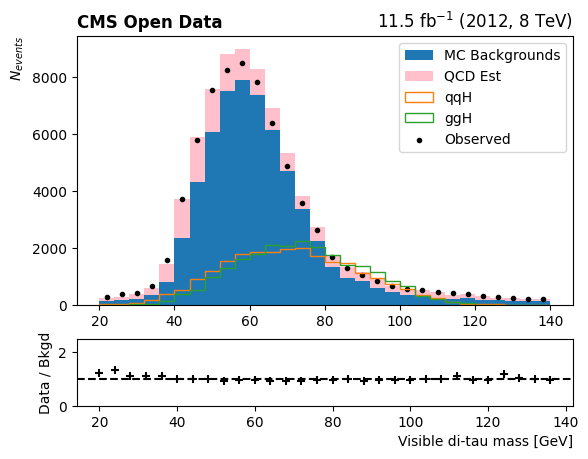

In [45]:
# Create 2 plots
fig, (ax1, ax2) = plt.subplots( nrows=2, height_ratios=[4,1])

# Stack the QCD estimation with the MC backgrounds
all_bkgdcounts = bkgdcounts + QCDcounts
ax1.hist( [bins[:-1], bins[:-1]], bins, weights=[bkgdcounts, QCDcounts], stacked=True, color=['C0', 'pink'], label=['MC Backgrounds', 'QCD Est'])

# Redraw the other things
ax1.hist(bins[:-1], bins, weights=qqHcounts, histtype='step', color='C1', label='qqH')
ax1.hist(bins[:-1], bins, weights=ggHcounts, histtype='step', color='C12', label='ggH')
ax1.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), datacounts, marker='.', color='black', label='Observed')

# Beautify
ax1.set_ylabel(r'$N_{events}$', loc='top')
ax1.set_title('CMS Open Data', fontweight='bold', loc='left')
ax1.set_title(r'11.5 fb$^{-1}$ (2012, 8 TeV)', loc='right')
ax1.legend()

# Add a Ratio Plot
ax2.scatter(bins[:-1], datacounts / all_bkgdcounts, marker='+', color='black')
ax2.axhline(1.0, linestyle='--', color='black')

ax2.set_xlabel('Visible di-tau mass [GeV]', loc='right')
ax2.set_ylabel('Data / Bkgd')
ax2.set_ylim( [0, 2.5])

# Show the plots now...
plt.show()

Our background prediction now lines up much better with the observed data! Is there a better way we could have extrapolated the QCD contribution from the CR?

#Topics for Discussion:
- What if we had chosen a different set of variables?
- Can we trust this estimate? What steps would be necessary to validate it?
- How do we quantify the errors in this estimation?
- What are the limitations of this method?
- Can this estimate for for other variables?

#Extra Fun
For fun, let's make one extra pretty plot, showing the contributions from all of the backgrounds

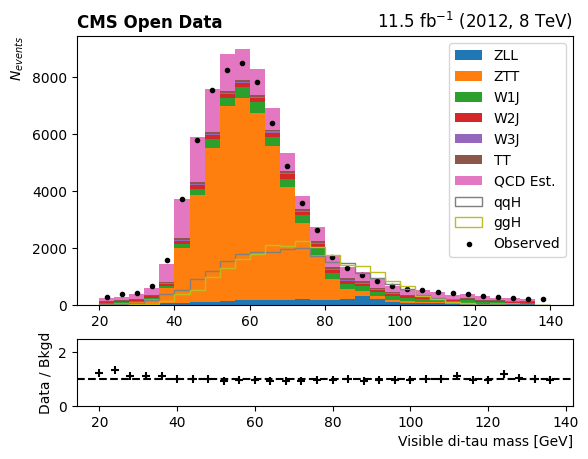

In [48]:
# Create 2 plots
fig, (ax1, ax2) = plt.subplots( nrows=2, height_ratios=[4,1])

# Separate the MC backgrounds and their weights
m_vis   = [OS_events[OS_events['label']==label]['m_vis'] for label in backgrounds]
weights = [OS_events[OS_events['label']==label]['weight'] for label in backgrounds]

# Now create histograms for each (np.histogram returns a tuple)
counts_and_bins = [np.histogram( c, weights=w, bins=30, range=[20, 140]) for c, w in zip(m_vis, weights)]

# Add in the QCD histogram we've already created
counts_and_bins.append((QCDcounts, bins))

# And now stack them all
ax1.stackplot( counts_and_bins[0][1][:-1], [i[0] for i in counts_and_bins], step='post', labels=backgrounds+['QCD Est.'])

# Redraw the other things
ax1.hist(bins[:-1], bins, weights=qqHcounts, histtype='step', label='qqH')
ax1.hist(bins[:-1], bins, weights=ggHcounts, histtype='step', label='ggH')
ax1.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), datacounts, marker='.', color='black', label='Observed')
# ax1.scatter(bins[:-1], datacounts, marker='.', color='black', label='Observed')

# Beautify
ax1.set_ylabel(r'$N_{events}$', loc='top')
ax1.set_title('CMS Open Data', fontweight='bold', loc='left')
ax1.set_title(r'11.5 fb$^{-1}$ (2012, 8 TeV)', loc='right')
ax1.legend()

# Add a Ratio Plot
ax2.scatter(bins[:-1], datacounts / all_bkgdcounts, marker='+', color='black')
ax2.axhline(1.0, linestyle='--', color='black')

ax2.set_xlabel('Visible di-tau mass [GeV]', loc='right')
ax2.set_ylabel('Data / Bkgd')
ax2.set_ylim( [0, 2.5])

# Show the plots now...
plt.show()

# Notes

This exercise is based heavily on an existing [CMS Open Data workshop](https://cms-opendata-workshop.github.io/workshop-lesson-abcd-method/), designed by Santeri Laurila (CERN) and Stefan Wunsch (CERN).

Adaptations were made to remove the need for ROOT to be used.